# Modeling Revenue and forecasting

## EDA of revenue trends

Let's begin with understanding the revenue trends of long standing companies. The questions I have in mind
1. Are there generalizable trends in revenue or grwoth rate history?
2. Is it possible to group companies based on certain criteria where the revenue trends can be generalized accurately?
3. What is the probability distribution of revenue growth rates at 5,10,15,20,25,30 etc year mark?


#### Understand the trends of the following metrics

$$Revenue\ Vs\ Time:\ R/T$$ 
$$Revenue\ Growth\ Rate:\ \frac{dR}{dT}$$
$$Rate\ of\ Revenue\ Growth\ Rate:\ \frac{d^2 R}{dT^2}$$ 

--------------------------------------------------------------------------------------------------------------------------------

In [2]:
import pandas as pd
import numpy as np
import sys
sys.path.append("../..")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF

from data.scripts.simplified_finance_stats.fin_stats import fin_stats
from data.scripts.simplified_finance_stats.fin_ratios import get_ratios
from data.scripts.simplified_finance_stats.fin_stats_2 import fin_stats_2
from data.scripts.simplified_finance_stats.stock_stats import stock_stats

pd.options.display.max_rows = 999

### Initialize Data

In [3]:
# Set path for data
base_path = '../../data/'
sheets_path = 'combined_simplified/combined_all_us.csv' 
other_path = 'combined_simplified/others_all_us.csv'
mkt_path = 'combined_simplified/stock_stats_all_us.csv'

equity_list_path = '../../equity_list/all_us_list.csv'

In [4]:
# setup all data
finances = fin_stats(base_path + sheets_path)
fin_others = fin_stats_2(base_path + other_path)
mkt_data = stock_stats(base_path + mkt_path)

Total Missing tickers: 181
Total Missing tickers: 181
Total Missing tickers: 181


In [5]:
equity_list = pd.read_csv(equity_list_path)['tick'].tolist()

### Data Preprocessing

For now, only considering companies with more than 30 year history

In [6]:
# Methods for data processing

def get_processed_sheet(tick):
    """Returns processed income sheet with no 0.0 revenue fields"""
    df = finances.get_sheet(tick,"income_sheet")
    revt = df.loc['revt']
    ix = revt[(revt!=0.0)].index.tolist()
    df = df[ix]
    return df

def get_time_hist(tick):
    """Returns the number of years the company has been listed on stock exchange"""
    df = get_processed_sheet(tick)
    return df.shape[1]


In [7]:
# Create a list of equities with 30 year or more of historical data

equity_list_30_yr = []

for i,tick in enumerate(equity_list):
    try:
        if get_time_hist(tick) > 30:
            equity_list_30_yr.append(tick)
    
    except:
        pass
        
print("Number of companies with atleast 30 year history: %i"%len(equity_list_30_yr))
    

AFP not found in income_sheet
CWTR not found in income_sheet
CTYN not found in income_sheet
CWE not found in income_sheet
CNF not found in income_sheet
CTC not found in income_sheet
DOW not found in income_sheet
DOYL not found in income_sheet
EK not found in income_sheet
HB not found in income_sheet
ICX not found in income_sheet
KLU not found in income_sheet
KES not found in income_sheet
KRN not found in income_sheet
MOB not found in income_sheet
MMED not found in income_sheet
NAS not found in income_sheet
GAS not found in income_sheet
OMAH not found in income_sheet
OVT not found in income_sheet
PICN not found in income_sheet
PINK not found in income_sheet
PITS not found in income_sheet
RJR not found in income_sheet
RLM not found in income_sheet
SAFC not found in income_sheet
SPC not found in income_sheet
SY not found in income_sheet
SNS not found in income_sheet
VSTA not found in income_sheet
WPO not found in income_sheet
WSC not found in income_sheet
Z not found in income_sheet
ACD n

### $$Revenue\ Vs\ Time:\ R/T$$

Visualized the revenue trends.
It is observed there are no specific trends. To plot the figure, uncomment the plotting parts in the following section


### $$Revenue\ Growth\ Rate:\ \frac{dR}{dT}$$

In [8]:
# Visualizing the distribution of growth rates at uniform time intervals since the start of the company. In this case they are
# [5,10,15,20,25,30] year intervals. 

start_year = 4
end_year = 29
num_intervals = (end_year+1)/(start_year+1)
time_steps = list(np.linspace(start_year,end_year,num_intervals).astype(int))
n=len(equity_list_30_yr) # Number of companies
growth_rate_mat = np.zeros((n+1,num_intervals))

#plt.figure(figsize=(15,8))
#plt.hold(True)

for i,tick in enumerate(equity_list_30_yr):
    try:
        df = get_processed_sheet(tick).loc['revt']
        gr = df.pct_change().rolling(window=3).mean()
        gr_interval = gr.values[time_steps]
        growth_rate_mat[i,:] = gr_interval
        #df = pd.rolling_mean(df,4)
        #x = df.columns.tolist()[0:30]
        x = np.linspace(1,29,29)
        y = df.values[1:30]
        #plt.plot(x,y,alpha=0.5)
        #plt.ylim()
        
    except:
        print i,tick
        break


In [9]:
# Growth rate at different time intervals
df_grw_rate = pd.DataFrame(growth_rate_mat)
df_grw_rate.columns = [i+1 for i in time_steps]
df_grw_rate.head()

,5,10,15,20,25,30
0,0.014481,0.082957,0.183419,0.149682,0.187248,0.157694
1,0.152155,0.129999,0.125884,-0.071414,-0.022430,0.081947
2,0.022024,0.054887,0.347718,-0.073902,0.455520,0.011870
3,-0.044372,0.027117,0.110801,-0.024669,0.353071,0.140053
4,0.048737,0.032052,0.143611,0.147572,0.314755,0.174299


### Distribution of growth rates at time intervals

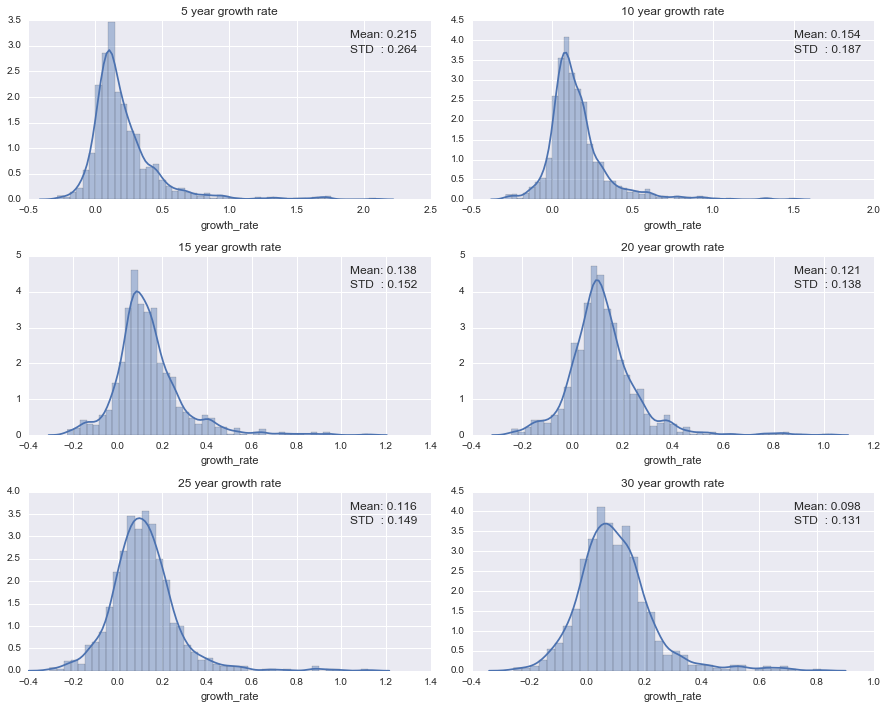

In [10]:
def rmv_outliers(x,perc_1=0.5,perc_2=99):
    """ Removes the outliers based on the given percentiles"""
    
    p1,p2 = np.percentile(x,[perc_1,perc_2])
    x2 = x[np.logical_and(x>=p1,x<=p2)]
    return x2

fig, ax = plt.subplots(3,2)
fig.set_size_inches(12.5,10)

# loop through the plots
c = 0

for i in range(3):
    for j in range(2):
        data=rmv_outliers(df_grw_rate[time_steps[c]+1].values)
        sns.distplot(data,ax=ax[i,j])
        ax[i,j].set_title("%s year growth rate"%str(time_steps[c]+1))
        ax[i,j].set_xlabel("growth_rate")
        ax[i,j].annotate("Mean: " + "%1.3f"%np.mean(data),xy=(0.8, 0.9), xycoords='axes fraction')
        ax[i,j].annotate("STD  : " + "%1.3f"%np.std(data),xy=(0.8, 0.82), xycoords='axes fraction')
        c += 1

plt.tight_layout()

Revenue growth at any interval is normally distributed. As expected, the mean revenue growth rate decreases with time. 

### CDF of Growth Rates

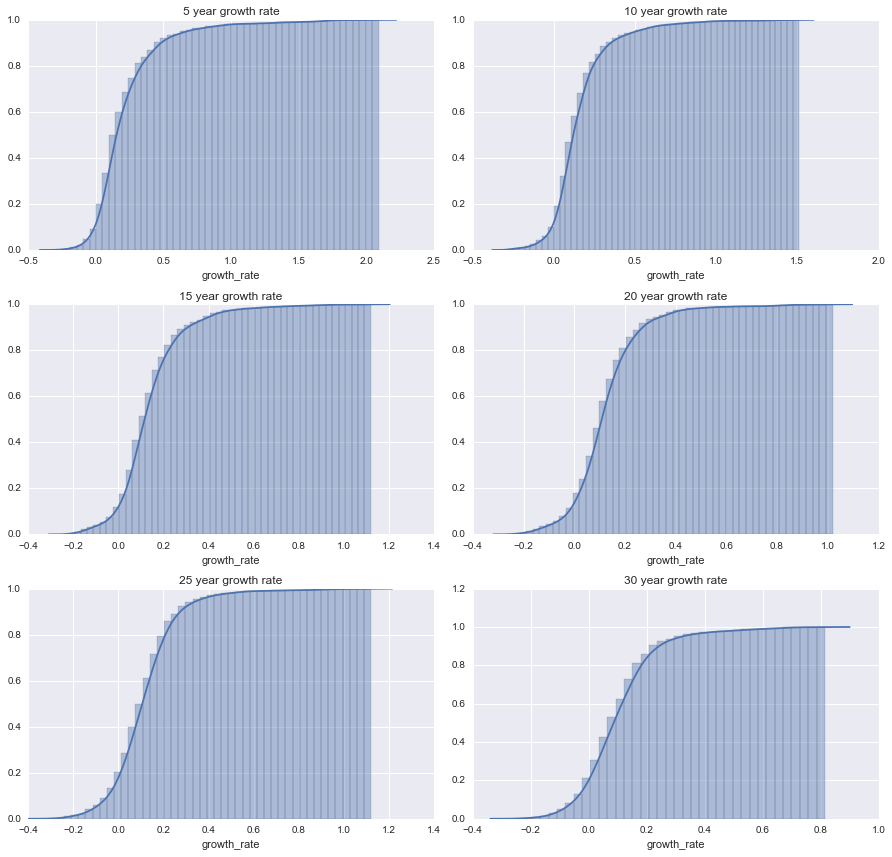

In [267]:
fig, ax = plt.subplots(3,2)
fig.set_size_inches(12.5,12)

# loop through the plots
c = 0

for i in range(3):
    for j in range(2):
        sns.distplot(rmv_outliers(df_grw_rate[time_steps[c]+1].values),hist_kws=dict(cumulative=True),
                     kde_kws=dict(cumulative=True),ax=ax[i,j])
        ax[i,j].set_title("%s year growth rate"%str(time_steps[c]+1))
        ax[i,j].set_xlabel("growth_rate")
        c += 1

plt.tight_layout()

### Mean revenue growth rate over time

We would like to see how the mean of revenue growth across different companies changes with time. From common sense we know, the growth rates decrease over time (most likely qudratically). Once confirmed, we can model our growth rate projections using quadratic model.

In [13]:
start_year = 0
end_year = 29
num_intervals = 30
time_steps = list(np.linspace(start_year,end_year,num_intervals).astype(int))
n=len(equity_list_30_yr) # Number of companies
growth_rate_mat = np.zeros((n+1,num_intervals))

for i,tick in enumerate(equity_list_30_yr):
    try:
        df = get_processed_sheet(tick).loc['revt']
        gr = df.pct_change().rolling(window=3).mean()
        gr_interval = gr.values[time_steps]
        growth_rate_mat[i,:] = gr_interval

    except:
        print i,tick
        break

# Growth rate at different time intervals
df_grw_r_all = pd.DataFrame(growth_rate_mat)
df_grw_r_all.columns = [i+1 for i in time_steps]
df_grw_r_all = df_grw_r_all.dropna(axis=1)
df_grw_r_all.head()

,4,5,6,7,8,9,10,11,12,13,...,21,22,23,24,25,26,27,28,29,30
0,0.063914,0.014481,0.023757,0.032160,0.082091,0.084343,0.082957,0.042270,0.036714,0.056000,...,0.146846,0.094914,0.091036,0.109771,0.187248,0.217206,0.205332,0.176614,0.153856,0.157694
1,0.132873,0.152155,0.162624,0.159131,0.168818,0.177656,0.129999,0.078317,0.031336,0.047999,...,-0.037454,-0.033654,-0.028797,-0.085786,-0.022430,0.042749,0.164297,0.204634,0.137500,0.081947
2,0.037287,0.022024,0.033902,0.044304,0.033566,0.047053,0.054887,0.075819,0.081563,0.091417,...,-0.038304,0.006940,0.170533,0.466356,0.455520,0.306946,0.014999,0.007258,0.011842,0.011870
3,0.004179,-0.044372,-0.011707,-0.007659,0.024414,-0.006536,0.027117,0.012005,-0.016465,0.014765,...,0.093410,0.337560,0.298204,0.314754,0.353071,0.403317,0.222418,0.122874,0.023977,0.140053
4,0.152289,0.048737,0.118984,0.123230,0.145314,0.010826,0.032052,0.065154,0.159050,0.128220,...,0.148666,0.147795,0.159939,0.187803,0.314755,0.252448,0.222051,0.082546,0.137230,0.174299


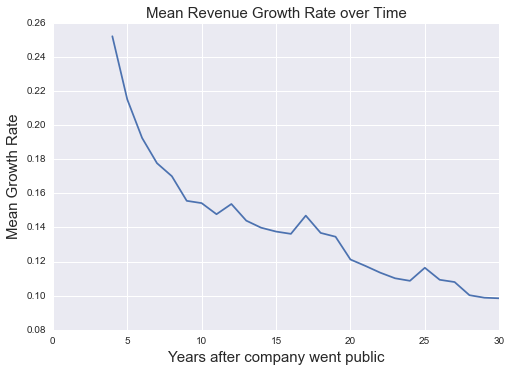

In [57]:
# Plotting the growth rate over time

mean_grw_r = {}
for i,year in enumerate(df_grw_r_all.columns.tolist()):
    y_tmp = rmv_outliers(df_grw_r_all[year].values)
    mean_grw_r[year] = np.mean(y_tmp)
    
x,y = mean_grw_r.keys(),mean_grw_r.values()   
plt.plot(x,y);
plt.title("Mean Revenue Growth Rate over Time",fontsize=15);
plt.xlabel("Years after company went public",fontsize=15);
plt.ylabel("Mean Growth Rate",fontsize=15);


Observation: On average the revenue growth rate follows a quadratic curve (as suspected).

This answers the question of trends in the historical data. Growth rates are more reasonable to predict and are generalizable to a certain extent. We can now try to fit a quadratic model to forecast growth rate based on the company timeline.

In [90]:
df_tmp = df_grw_r_all.copy()
for i,year in enumerate(df_tmp.columns.tolist()):
    zz = df_tmp[year].values
    zz = np.sort(zz)
    df_tmp[year] = zz

df_tmp = df_tmp.loc[4:885].reset_index(drop=True)

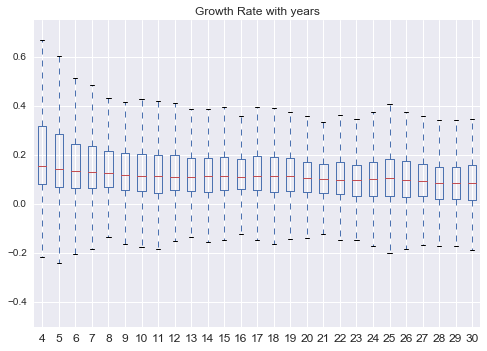

In [113]:
ax = df_tmp.boxplot(return_type='axes');
ax.set_ylim(-0.5,0.75);
ax.set_title('Growth Rate with years');


### $$Rate\ of\ Revenue\ Growth\ Rate:\ \frac{d^2 R}{dT^2}$$ 

In [165]:
# Build df of rate of growth rate
df_rgr = df_grw_r_all.pct_change(axis=1)
df_rgr = df_rgr.drop(labels=4,axis=1)
ix_to_rmv = df_rgr[df_rgr.isnull().sum(axis=1)>1].index.tolist() # remove nans
df_rgr = df_rgr.drop(ix_to_rmv,axis=0)

In [166]:
df_rgr.head()

,5,6,7,8,9,10,11,12,13,14,...,21,22,23,24,25,26,27,28,29,30
0,-0.773432,0.640604,0.353670,1.552604,0.027435,-0.016434,-0.490460,-0.131431,0.525290,0.435865,...,-0.018945,-0.353652,-0.040854,0.205789,0.705813,0.159992,-0.054670,-0.139859,-0.128860,0.024950
1,0.145116,0.068805,-0.021481,0.060874,0.052349,-0.268254,-0.397552,-0.599880,0.531741,1.045300,...,-0.475535,-0.101454,-0.144320,1.978984,-0.738530,-2.905830,2.843324,0.245516,-0.328070,-0.404024
2,-0.409344,0.539331,0.306801,-0.242361,0.401803,0.166493,0.381355,0.075764,0.120813,2.558362,...,-0.481699,-1.181178,23.573338,1.734705,-0.023236,-0.326162,-0.951133,-0.516148,0.631712,0.002363
3,-11.619010,-0.736166,-0.345802,-4.187763,-1.267703,-5.149123,-0.557298,-2.371517,-1.896736,2.283496,...,-4.786607,2.613736,-0.116589,0.055500,0.121736,0.142310,-0.448527,-0.447557,-0.804861,4.841038
4,-0.679970,1.441358,0.035678,0.179215,-0.925502,1.960700,1.032777,1.441155,-0.193841,-0.074934,...,0.007410,-0.005855,0.082165,0.174214,0.675991,-0.197955,-0.120409,-0.628256,0.662458,0.270124


In [180]:
def rmv_outliers_2(x,perc_1=2,perc_2=98):
    """ Removes the outliers based on the given percentiles"""
    
    p1,p2 = np.percentile(x,[perc_1,perc_2])
    x2 = x[np.logical_and(x>=p1,x<=p2)]
    return x2

rgr_mean = {}

for i,year in enumerate(df_rgr.columns.tolist()):
    
    rgr = rmv_outliers_2(df_rgr[year].values)
    rgr_mean[year] = np.mean(rgr)
    #sns.distplot(rgr)
    #plt.savefig("%i.png"%year)
    #plt.clf()

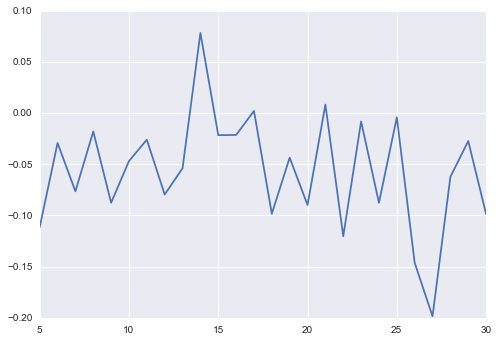

In [178]:
x2,y2 = rgr_mean.keys(),rgr_mean.values()
plt.plot(x2,y2)

In [183]:
df_tt = df_rgr.apply(np.sort,axis=0)
df_tt = df_tt.loc[19:861].reset_index(drop=True)

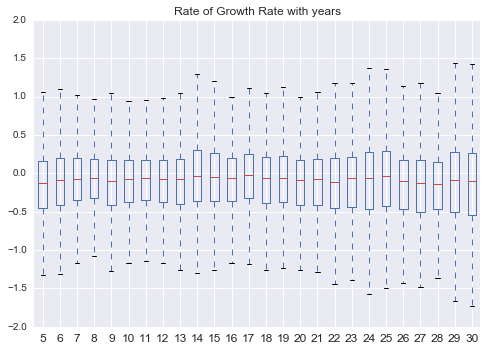

In [186]:
ax1 = df_tt.boxplot(return_type='axes');
ax1.set_ylim(-2,2);
ax1.set_title('Rate of Growth Rate with years');

In [193]:
ge = mkt_data.get_stock_data('GE')
utx = mkt_data.get_stock_data('UTX')

In [205]:
ge = ge.T
ge = ge.drop(['prcc_f'],axis=1)
ge.head()


,csho,mkvalt,prcc_c
1950,28.653,1425.48675,49.75
1951,28.727,1709.25650,59.50
1952,28.687,2086.97925,72.75
1953,28.688,2510.20000,87.50
1954,85.920,4016.76000,46.75


In [208]:
ge.columns = ['Number of Outstanding Shares (USD Millions)','Market Cap (USD Millions)','Closing Price']
ge.head()

,Number of Outstanding Shares (USD Millions),Market Cap (USD Millions),Closing Price
1950,28.653,1425.48675,49.75
1951,28.727,1709.25650,59.50
1952,28.687,2086.97925,72.75
1953,28.688,2510.20000,87.50
1954,85.920,4016.76000,46.75


In [209]:
ge.to_csv("GE.csv")